<a href="https://colab.research.google.com/github/itsmaul/bangkit-capstone/blob/main/All_Integrated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install tensorflowjs

# **Cashflow Analysis**

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflowjs as tfjs

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler

## **Visualisasi Data**

In [3]:
def preprocess_data_visualization(data):
  # Membaca file dataset
  data = pd.DataFrame(pd.read_json(data))

  # Menghitung total_income dan total_expense
  data['total_income'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Income' else 0, axis=1)
  data['total_expense'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Expense' else 0, axis=1)

  # Menghitung net_cashflow
  data['net_cashflow'] = data['total_income'] - data['total_expense']

  # Mengelompokkan berdasarkan bulan
  data['month'] = pd.to_datetime(data['date']).dt.to_period('M')

  # Menghitung total per bulan
  summary = data.groupby('month').agg(
    total_income = ('total_income', 'sum'),
    total_expense = ('total_expense', 'sum'),
    net_cashflow = ('net_cashflow', 'sum')
  ).reset_index()

  # Period ke timestamp
  summary['month'] = summary['month'].dt.to_timestamp()

  return summary

In [4]:
data = preprocess_data_visualization('merger_dataset.json')
data.head(10)

,month,total_income,total_expense,net_cashflow
0,2023-08-01,1390000,1412950,-22950
1,2023-09-01,1607000,1443530,163470
2,2023-10-01,1510000,1652785,-142785
3,2023-11-01,1200000,1077068,122932
4,2023-12-01,1750000,1829508,-79508
5,2024-01-01,9735000,11400361,-1665361
6,2024-02-01,19201015,18971500,229515
7,2024-03-01,3620000,2670818,949182
8,2024-04-01,6250101,4098822,2151279
9,2024-05-01,4527000,6434944,-1907944


In [5]:
#Min-Max Scaler Initialization
income_scaler = MinMaxScaler(feature_range=(0, 1))
expense_scaler = MinMaxScaler(feature_range=(0, 1))
cashflow_scaler = MinMaxScaler(feature_range=(0, 1))

In [6]:
def time_series(data):
  # Rescaling dengan MinMaxScaler
  total_income = income_scaler.fit_transform(data[['total_income']])
  total_expense = expense_scaler.fit_transform(data[['total_expense']])
  net_cashflow = cashflow_scaler.fit_transform(data[['net_cashflow']])

  # Assign value variabel time dan series
  time = data['month'].tolist()
  income = total_income.tolist()
  expense = total_expense.tolist()
  net_cashflow = net_cashflow.tolist()

  return time, income, expense, net_cashflow

In [7]:
TIME, INCOME, EXPENSE, NET_CASHFLOW = time_series(data)

INCOME_SCALED = income_scaler.inverse_transform(np.array(INCOME).reshape(-1,1)).flatten()
EXPENSE_SCALED = expense_scaler.inverse_transform(np.array(EXPENSE).reshape(-1,1)).flatten()
NET_CASHFLOW_SCALED = cashflow_scaler.inverse_transform(np.array(NET_CASHFLOW).reshape(-1,1)).flatten()

In [8]:
def plot_value(time, value, label):
  plt.plot(time, value, label = label)
  formatter = ticker.ScalarFormatter()
  formatter.set_scientific(False)
  plt.xlabel("Bulan Transaksi")
  plt.ylabel("Jumlah Uang")
  plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
  plt.gca().yaxis.set_major_formatter(formatter)
  plt.legend()
  plt.gcf().autofmt_xdate()
  plt.show()

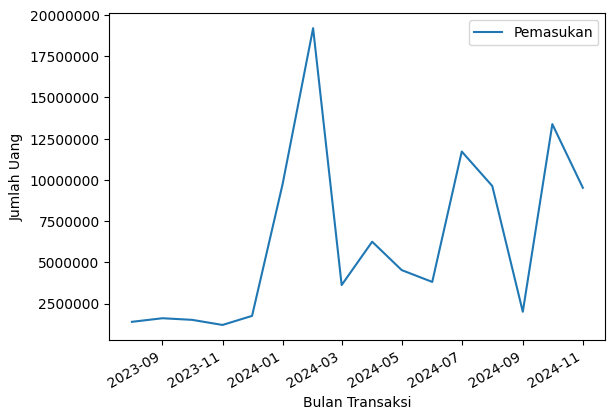

In [9]:
plot_value(TIME, INCOME_SCALED, "Pemasukan")

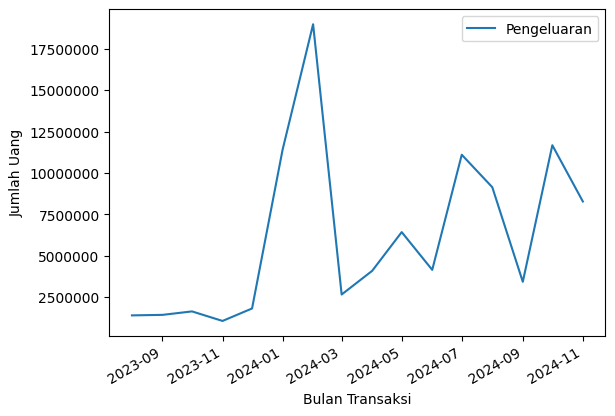

In [10]:
plot_value(TIME, EXPENSE_SCALED, "Pengeluaran")

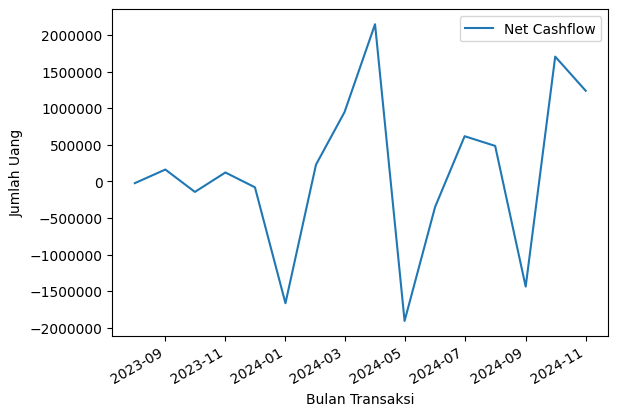

In [11]:
plot_value(TIME, NET_CASHFLOW_SCALED, "Net Cashflow")

# **Anomaly Detection (Time Series)**

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.subplots(figsize=(30, 6))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.gcf().autofmt_xdate()
    plt.show()

In [13]:
def train_val_split(time, series):
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [14]:
def windowed_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)

    return dataset

In [15]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.4, kernel_regularizer=l2(0.01))),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.4, kernel_regularizer=l2(0.01))),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

In [16]:
def create_model():

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=["mse"])

    return model

In [17]:
# Min-Max Scaler Initialization
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data_anomaly(file):

    data = pd.DataFrame(pd.read_json(file))

    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])

    series = scaler.fit_transform(data[['amount']])

    # Assign value variable time and series
    time = data['date'].tolist()
    series = series.flatten()

    return time, series

In [18]:
DATA_PATH = 'expense_data.json'

TIME, SERIES = preprocess_data_anomaly(DATA_PATH)

In [19]:
# Global Variables

split_ratio = 0.75
SPLIT_TIME = int(len(SERIES) * split_ratio)
WINDOW_SIZE = 32
BATCH_SIZE = 48
SHUFFLE_BUFFER_SIZE = 100

## **Anomalies Plot**

In [20]:
def plot_series_with_anomalies(time, true_series, forecast, threshold_factor=2):

    error = np.abs(true_series - forecast)
    threshold = threshold_factor * np.mean(error)

    # Anomaly Identify
    anomalies = error > threshold
    anomaly_time = np.array(time)[anomalies]
    anomaly_values = np.array(true_series)[anomalies]

    # Plot time series dan forecast
    plt.figure(figsize=(30, 6))
    plt.plot(time, true_series, label='True Series', color='blue')
    plt.plot(time, forecast, label = 'Forecast', color='orange', linestyle='--')

    # Anomaly Highlight
    plt.scatter(anomaly_time, anomaly_values, color='red', label='Data Anomaly', zorder=5)

    plt.xlabel("Time")
    plt.ylabel("Data")
    plt.title("Forecast with Anomaly")
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [21]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)
valid_dataset = windowed_dataset(series_valid, window_size=WINDOW_SIZE)

In [22]:
# Get your uncompiled model
uncompiled_model = create_uncompiled_model()

In [23]:
example_batch = train_dataset.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (48, 1)


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [24]:
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 32, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 32, 256)             │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,505 (1.27 MB)

 Trainable params: 333,505 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model = create_model()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 50))
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=100, callbacks=[lr_schedule, reduce_lr, early_stopping])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 329ms/step - loss: 6.2774 - mse: 0.0091 - val_loss: 6.1678 - val_mse: 0.0040 - learning_rate: 1.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step - loss: 6.1356 - mse: 0.0059 - val_loss: 6.0241 - val_mse: 0.0039 - learning_rate: 1.0471e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - loss: 5.9929 - mse: 0.0114 - val_loss: 5.8736 - val_mse: 0.0039 - learning_rate: 1.0965e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - loss: 5.8379 - mse: 0.0051 - val_loss: 5.7174 - val_mse: 0.0039 - learning_rate: 1.1482e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 5.6834 - mse: 0.0108 - val_loss: 5.5566 - val_mse: 0.0039 - learning_rate: 1.2023e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - loss: 5.5212 - mse: 0.0100 - val_loss: 5.3919 - val_mse: 0.0039 - learning_rate: 1.2589e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - loss: 5.3544 - mse: 0.0073 - val_loss: 5.2239 - val_mse: 0.0039 - learning_r

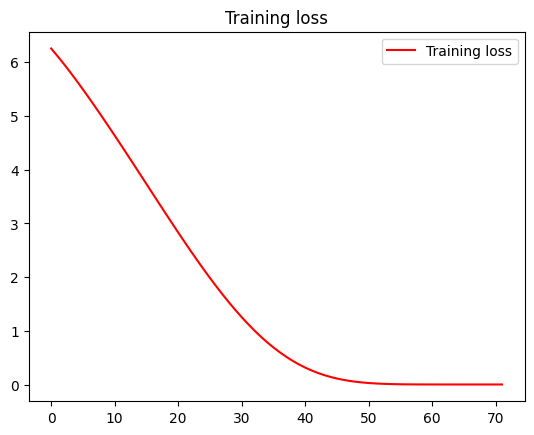

In [26]:
# Plot the training loss for each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

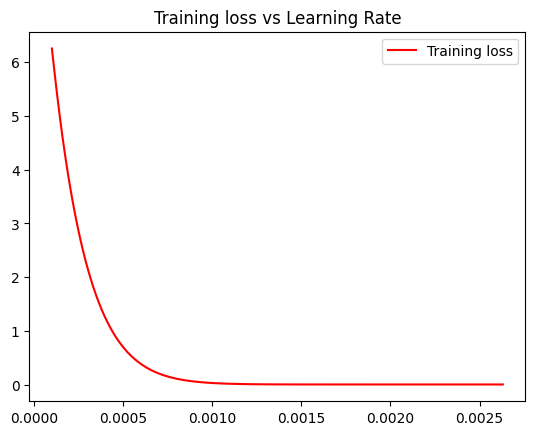

In [27]:
# Plot the training loss for each learning rate

lr = history.history['learning_rate']

plt.plot(lr, loss, 'r', label='Training loss')
plt.title('Training loss vs Learning Rate')
plt.legend(loc=0)
plt.show()

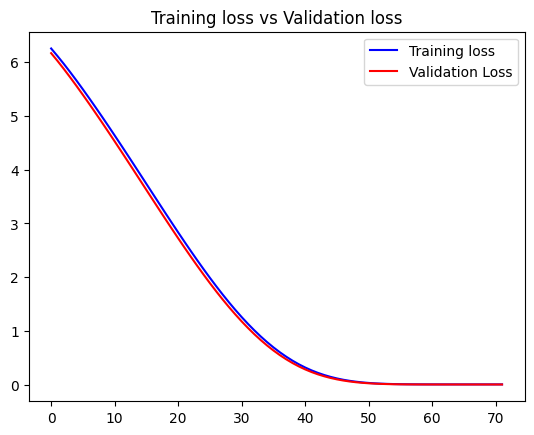

In [28]:
# Plot the training loss for each learning rate

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training loss vs Validation loss')
plt.legend()
plt.show()

## **Evaluate Forecast**

In [29]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

In [30]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast[:,-1]

In [31]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step


<Figure size 3000x600 with 0 Axes>

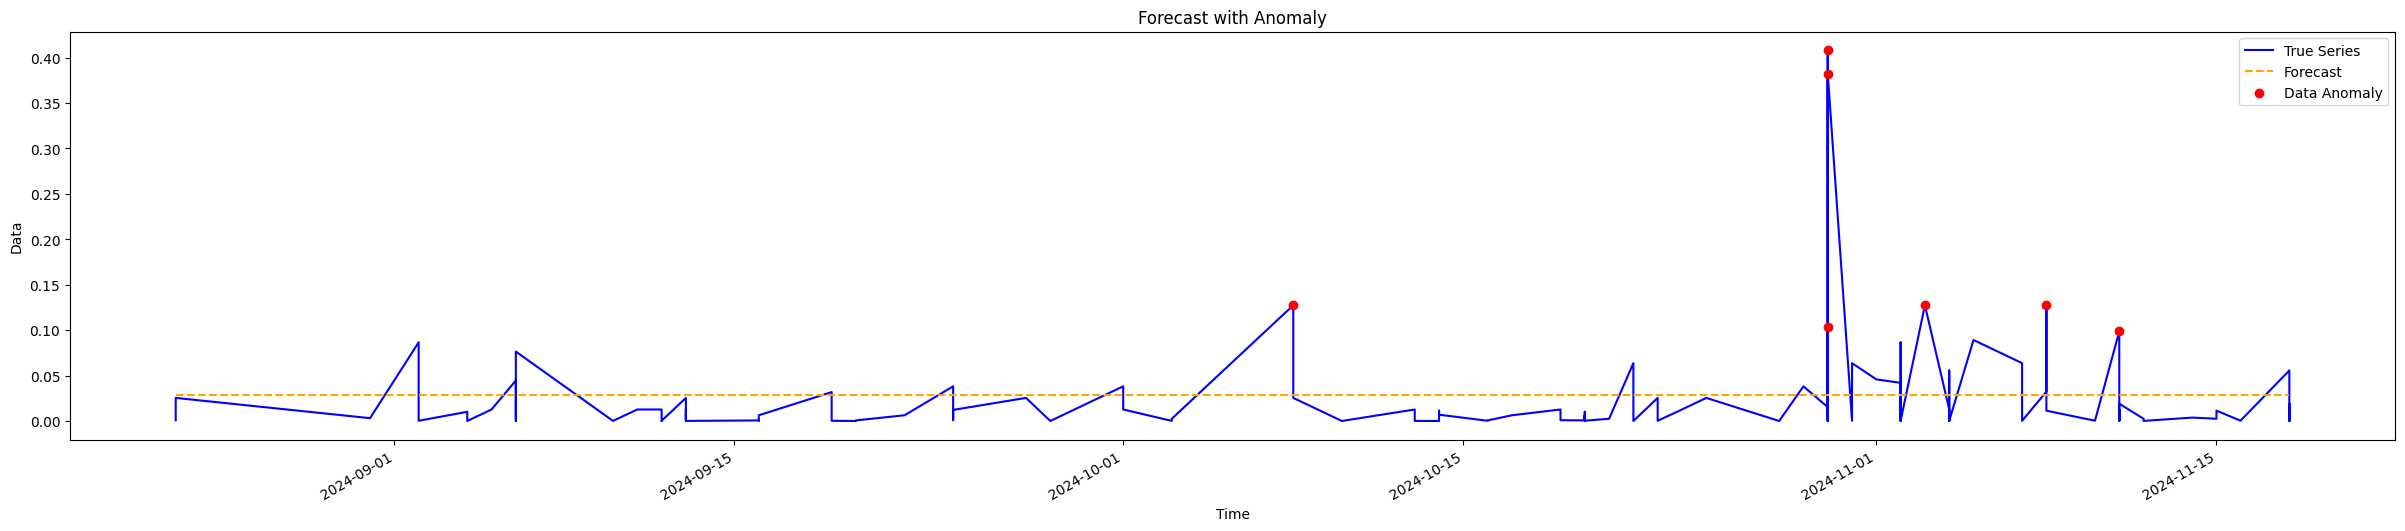

In [32]:
# Plot series

plt.figure(figsize=(30, 6))
plot_series_with_anomalies(TIME[-len(rnn_forecast):], SERIES[-len(rnn_forecast):], rnn_forecast)

<Figure size 3000x600 with 0 Axes>

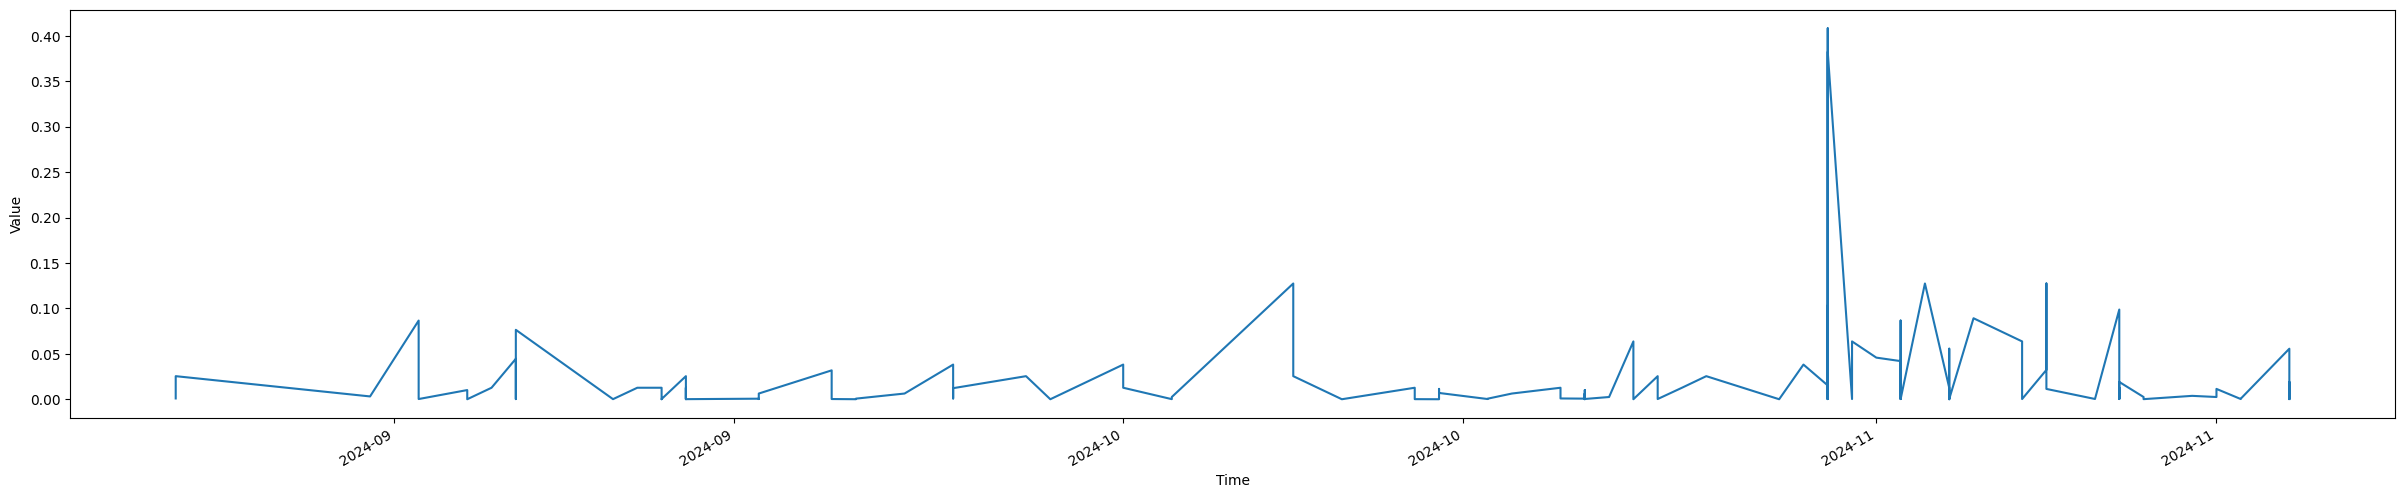

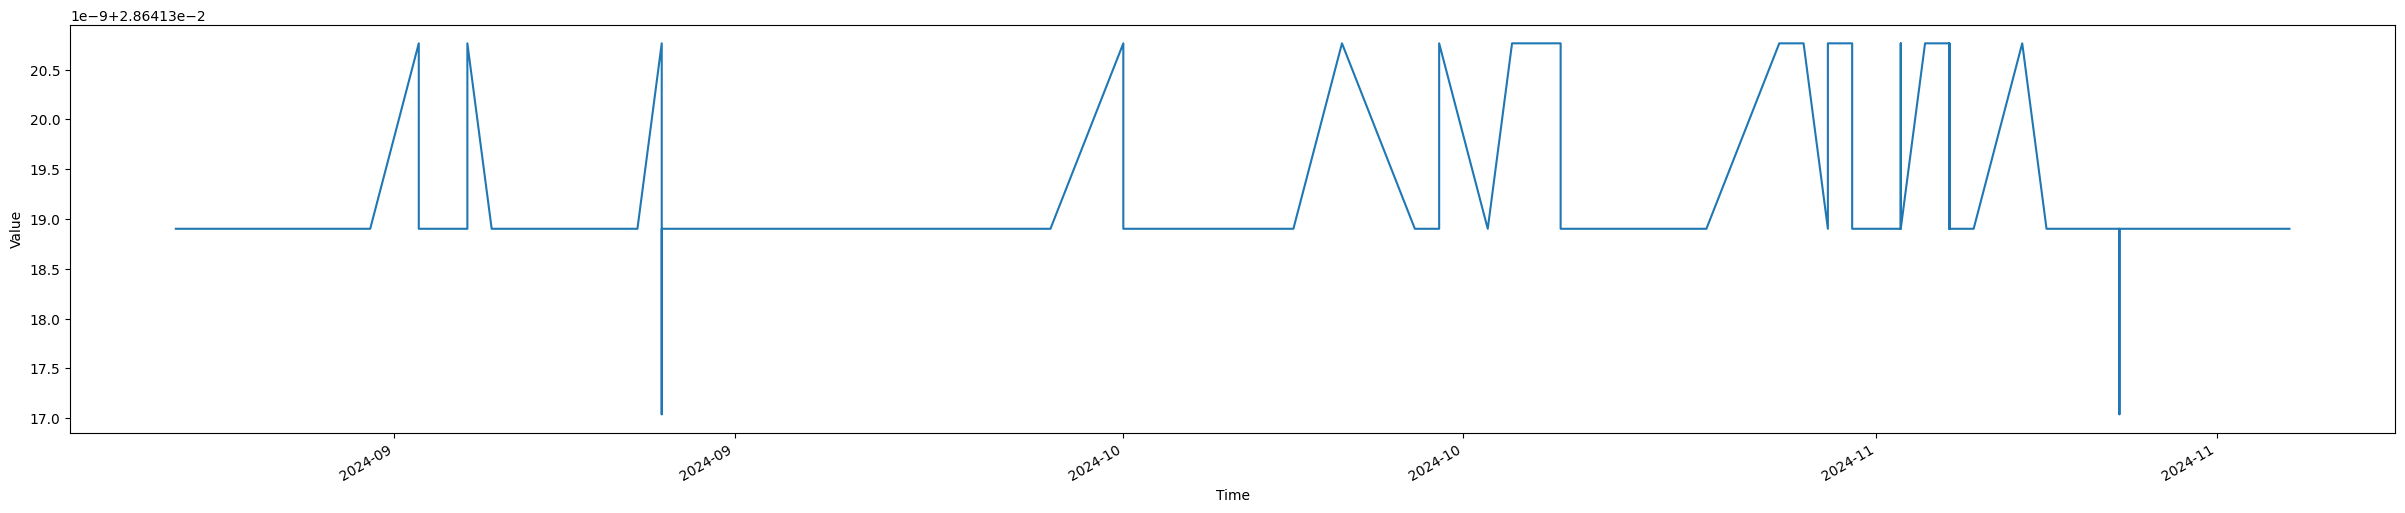

In [33]:
# Plot the forecast
plt.figure(figsize=(30, 6))

plot_series(time_valid[-(len(rnn_forecast)):], series_valid[-(len(rnn_forecast)):])
plot_series(time_valid[-(len(rnn_forecast)):], rnn_forecast)

In [34]:
mse, mae = compute_metrics(series_valid[-(len(rnn_forecast)):], rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 0.00, mae: 0.03 for forecast


## **Convert Model to TFJS**

In [35]:
tfjs.converters.save_keras_model(model, 'model_timeseries')

failed to lookup keras version from the file,
    this is likely a weight only file


In [36]:
# saved_model_path = "./model_timeseries.h5"

# model.save(saved_model_path)

In [37]:
# #Tensorflowjs converter

# from tensorflow.keras.models import load_model

# # Load the .h5 model
# model = load_model('model_timeseries.h5')

# # Save the architecture to a JSON file
# with open('model_timeseries.json', 'w') as json_file:
#     json_file.write(model.to_json())

# **Anomaly Detection (Autoencoder)**

In [38]:
def preprocess_data(data):
    # Convert 'date' to datetime and extract features
    data['date'] = pd.to_datetime(data['date'])
    data['day_of_week'] = data['date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
    data['month'] = data['date'].dt.month           # Month of the year (1=January, 12=December)
    data['day_of_month'] = data['date'].dt.day      # Day of the month (1-31)

    # Select relevant features
    features = ['amount', 'day_of_week', 'month', 'day_of_month']
    data = data[features]

    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    return data_scaled, data, scaler

In [39]:
def build_autoencoder(input_dim):

    autoencoder = models.Sequential([
        layers.Input(shape=(input_dim,)),       # Input layer
        layers.Dense(32, activation='relu'),    # Encoder
        layers.Dense(16, activation='relu'),    # Encoder
        layers.Dense(8, activation='relu'),     # Bottleneck
        layers.Dense(16, activation='relu'),    # Decoder
        layers.Dense(32, activation='relu'),    # Decoder
        layers.Dense(input_dim, activation='sigmoid')  # Output layer
    ])
    autoencoder.compile(optimizer=optimizers.Adam(), loss='mse')

    return autoencoder

In [40]:
def detect_anomalies(autoencoder, data_scaled, original_data, scaler, percentile=95):

    # Reconstruct the input data
    reconstructed = autoencoder.predict(data_scaled)
    mse = np.mean(np.power(data_scaled - reconstructed, 2), axis=1)  # Reconstruction error

    # Set anomaly threshold
    threshold = np.percentile(mse, percentile)

    # Flag anomalies
    original_data['reconstruction_error'] = mse
    original_data['is_anomaly'] = mse > threshold

    # Filter anomalies
    anomalies = original_data[original_data['is_anomaly']]

    return original_data, anomalies

In [41]:
def plot_results(processed_data, anomalies):
    """
    Plots the data, highlighting anomalies in red and normal data in blue.

    Parameters:
        processed_data (pd.DataFrame): Dataframe with anomaly status.
        anomalies (pd.DataFrame): Detected anomalies.
    """
    plt.figure(figsize=(10, 6))

    # Plot normal data
    normal_data = processed_data[~processed_data['is_anomaly']]
    plt.scatter(normal_data.index, normal_data['amount'], color='blue', label='Normal', alpha=0.6)

    # Plot anomalies
    plt.scatter(anomalies.index, anomalies['amount'], color='red', label='Anomaly', alpha=0.8)

    # Add labels and legend
    plt.title('Anomaly Detection in Financial Transactions')
    plt.xlabel('Index')
    plt.ylabel('Amount')
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
def main_pipeline(data, epochs=50, batch_size=16, percentile=95):

    # Preprocess the data
    data_scaled, processed_data, scaler = preprocess_data(data)

    # Build the autoencoder
    input_dim = data_scaled.shape[1]
    autoencoder = build_autoencoder(input_dim)

    # Train the autoencoder
    history = autoencoder.fit(data_scaled, data_scaled, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

    # Detect anomalies
    processed_data, anomalies = detect_anomalies(autoencoder, data_scaled, processed_data, scaler, percentile=percentile)

    # Plot results
    plot_results(processed_data, anomalies)

    return autoencoder, processed_data, anomalies, scaler

In [43]:
def predict_pipeline(model, new_data, scaler, percentile):

    # Preprocess new data
    # Extract date-based features if not already extracted
    if 'day_of_week' not in new_data.columns:
        new_data['date'] = pd.to_datetime(new_data['date'])
        new_data['day_of_week'] = new_data['date'].dt.dayofweek
        new_data['month'] = new_data['date'].dt.month
        new_data['day_of_month'] = new_data['date'].dt.day
        new_data = new_data[['amount', 'day_of_week', 'month', 'day_of_month']]

    # Normalize the data using the scaler from training
    new_data_scaled = scaler.transform(new_data)

    # Use model to reconstruct data
    reconstructed = model.predict(new_data_scaled)
    mse = np.mean(np.power(new_data_scaled - reconstructed, 2), axis=1)

    # Detect anomalies
    # Set anomaly threshold
    threshold = np.percentile(mse, percentile)

    # Flag the anomalies
    new_data['reconstruction_error'] = mse
    new_data['is_anomaly'] = mse > threshold

    # Filter anomalies
    anomalies = new_data[new_data['is_anomaly']]

    # Plot results
    plot_results(new_data, anomalies)

    return new_data, anomalies

In [44]:
def training_pipeline(model, data, scaler, epochs=100, batch_size=16):

    # Preprocess the data using the existing scaler
    if 'day_of_week' not in data.columns:
        data['date'] = pd.to_datetime(data['date'])
        data['day_of_week'] = data['date'].dt.dayofweek
        data['month'] = data['date'].dt.month
        data['day_of_month'] = data['date'].dt.day
        data = data[['amount', 'day_of_week', 'month', 'day_of_month']]

    data_scaled = scaler.transform(data)

    # Retrain the autoencoder
    model.fit(data_scaled, data_scaled, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

    return model

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1042
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0608
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 13/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 14/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 15/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0

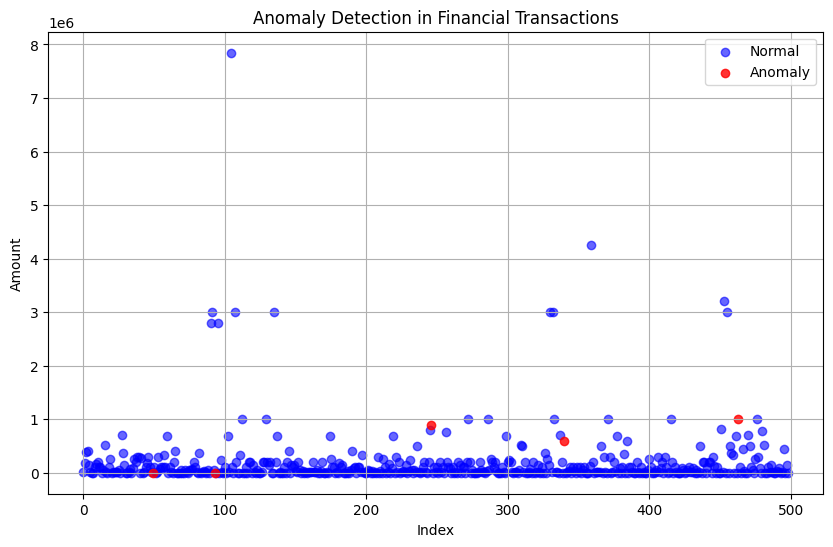

Processed Data with Anomaly Status:
     amount  day_of_week  month  day_of_month  reconstruction_error  \
0     20000            3      8             3              0.000175   
1    186450            1      8             8              0.000075   
2    384000            5      8            12              0.000286   
3    400000            5      8            12              0.000310   
4    150000            0      8            14              0.000059   
..      ...          ...    ...           ...                   ...   
494    5500            5     11            16              0.000096   
495  437000            0     11            18              0.000208   
496    2500            0     11            18              0.000206   
497  150000            0     11            18              0.000103   
498    2500            0     11            18              0.000206   

     is_anomaly  
0         False  
1         False  
2         False  
3         False  
4         False  
.. 

In [45]:
if __name__ == "__main__":

    data = pd.read_json('expense_data.json')

    # Run the pipeline
    autoencoder, processed_data, anomalies, scaler = main_pipeline(data, epochs=100, batch_size=4, percentile=99)

    # Display results
    print("Processed Data with Anomaly Status:")
    print(processed_data)

    print("\nDetected Anomalies:")
    print(anomalies)

In [46]:
pf_data = pd.read_json('expense_data.json')

training_pipeline(model=autoencoder, data=pf_data, scaler=scaler, epochs=100, batch_size=4)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5465e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8780e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7529e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4774e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8096e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0652e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4473e-04
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0346e-04
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7714e-04
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4755e-04
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0836e-04
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1138e-04
Epoch 13/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8689e-04
Epoch 14/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

<Sequential name=sequential_2, built=True>

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


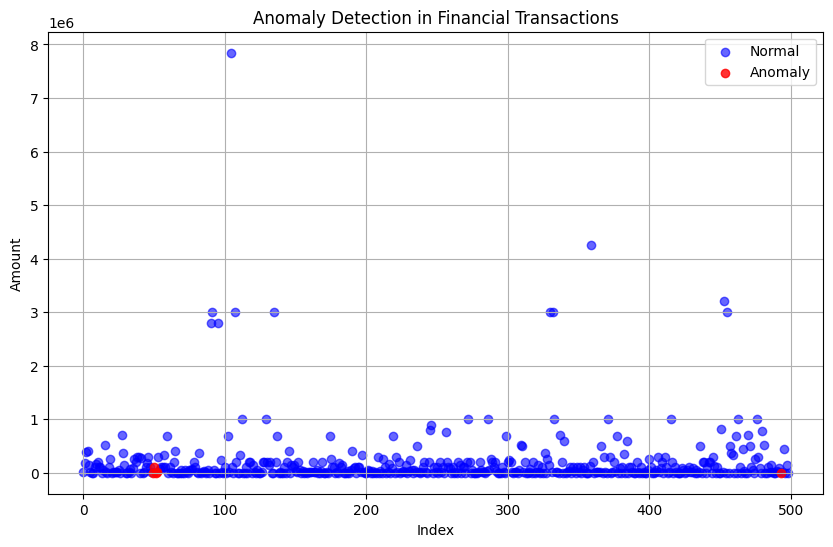

(     amount  day_of_week  month  day_of_month  reconstruction_error  \
 0     20000            3      8             3              0.000097   
 1    186450            1      8             8              0.000132   
 2    384000            5      8            12              0.000536   
 3    400000            5      8            12              0.000532   
 4    150000            0      8            14              0.000356   
 ..      ...          ...    ...           ...                   ...   
 494    5500            5     11            16              0.000891   
 495  437000            0     11            18              0.000345   
 496    2500            0     11            18              0.000419   
 497  150000            0     11            18              0.000400   
 498    2500            0     11            18              0.000419   
 
      is_anomaly  
 0         False  
 1         False  
 2         False  
 3         False  
 4         False  
 ..          ...  
 

In [47]:
pf_data = pd.read_json('expense_data.json')

predict_pipeline(model=autoencoder, new_data=pf_data, scaler=scaler, percentile=99)

In [48]:
pf_data = pd.read_json('income_data.json')

training_pipeline(model=autoencoder, data=pf_data, scaler=scaler, epochs=100, batch_size=4)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010    
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1082e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6634e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2416e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2028e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4334e-04
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5441e-04
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1729e-04
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7679e-04 
Epoch 15/100
27/27 ━━━━━━━━━━━

<Sequential name=sequential_2, built=True>

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


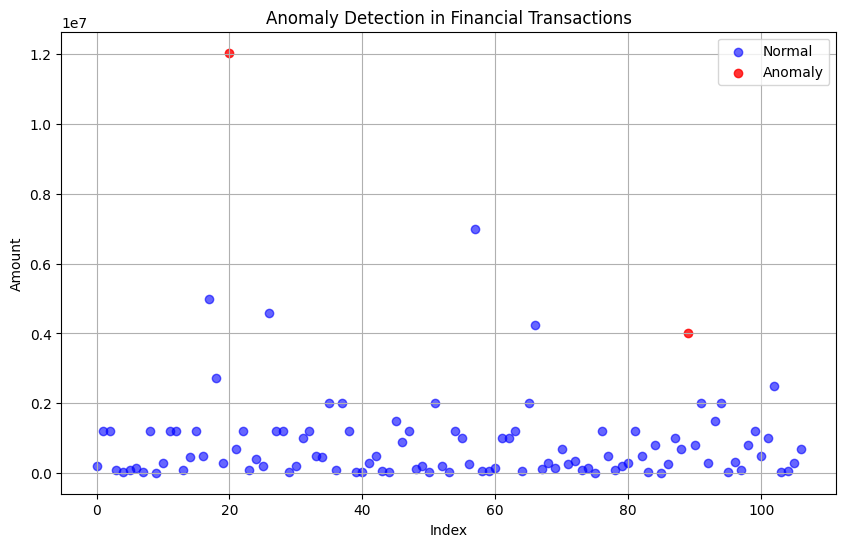

(      amount  day_of_week  month  day_of_month  reconstruction_error  \
 0     190000            1      8             8              0.000022   
 1    1200000            4      8            11              0.000069   
 2    1200000            4      9             1              0.000105   
 3     100000            0      9             4              0.000016   
 4      37000            3      9            14              0.000048   
 ..       ...          ...    ...           ...                   ...   
 102  2500000            3     11             7              0.000141   
 103    40000            1     11            12              0.000055   
 104    50000            2     11            13              0.000093   
 105   300000            4     11            15              0.000186   
 106   700000            0     11            18              0.000116   
 
      is_anomaly  
 0         False  
 1         False  
 2         False  
 3         False  
 4         False  
 ..     

In [49]:
pf_data = pd.read_json('income_data.json')

predict_pipeline(model=autoencoder, new_data=pf_data, scaler=scaler, percentile=99)

## **Convert Model to TFJS**

In [50]:
saved_model_path = "./model_autoencoder.h5"

model.save(saved_model_path)

In [51]:
#Tensorflowjs converter

from tensorflow.keras.models import load_model

# Load the .h5 model
model = load_model('model_autoencoder.h5')

# Save the architecture to a JSON file
with open('model_autoencoder.json', 'w') as json_file:
    json_file.write(model.to_json())

# **Anomaly Detection (Isolation Forest)**

In [52]:
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [53]:
class AdvancedFinancialAnomalyDetector:
    def __init__(self, contamination=0.05):
        self.scaler_amount = StandardScaler()
        self.model = IsolationForest(
            contamination=contamination,
            random_state=42,
            max_samples='auto',
            max_features=1.0
        )
        self.amount_column = None

    def preprocess_data(self, data):
        for col in ['amount', 'income', 'expense']:
            if col in data.columns:
                self.amount_column = col
                break
        else:
            raise KeyError("Neither 'amount', 'income', nor 'expense' column found in data")

        # Assuming you have a 'date' column in your data
        data['date'] = pd.to_datetime(data['date'])
        data['day_of_week'] = data['date'].dt.dayofweek
        data['month'] = data['date'].dt.month
        data['day_of_month'] = data['date'].dt.day

        # Normalisasi amount
        features = [self.amount_column, 'day_of_week', 'month', 'day_of_month']
        X = data[features].copy()
        X[self.amount_column] = self.scaler_amount.fit_transform(X[[self.amount_column]])

        return X

    def detect_anomalies(self, data):

        X = self.preprocess_data(data)

        # Prediksi anomali
        anomaly_labels = self.model.fit_predict(X)
        anomaly_scores = -self.model.score_samples(X)

        # Tambahkan informasi ke dataframe asli
        data['is_anomaly'] = anomaly_labels == -1
        data['anomaly_score'] = anomaly_scores

        return data

    def visualize_anomalies(self, data):

        plt.figure(figsize=(16, 12))
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

        # 1. Scatter Plot Anomali
        plt.subplot(2, 2, (1, 2))
        plt.title('Deteksi Anomali Keuangan', fontsize=12)
        plt.scatter(
            data[~data['is_anomaly']]['date'],
            data[~data['is_anomaly']][self.amount_column],
            c='blue',
            alpha=0.5,
            label='Normal'
        )
        plt.scatter(
            data[data['is_anomaly']]['date'],
            data[data['is_anomaly']][self.amount_column],
            c='red',
            label='Anomali'
        )
        plt.xlabel('Tanggal')
        plt.ylabel('Jumlah Transaksi')
        plt.legend()
        plt.xticks(rotation=45)

        # 2. Histogram Anomali Scores
        plt.subplot(2, 2, 3)
        plt.title('Distribusi Anomaly Scores', fontsize=12)
        sns.histplot(
            data=data,
            x='anomaly_score',
            hue='is_anomaly',
            multiple='stack'
        )
        plt.xlabel('Anomaly Score')
        plt.ylabel('Frekuensi')

        # 3. Pie Chart Proporsi Anomali
        plt.subplot(2, 2, 4)
        anomaly_counts = data['is_anomaly'].value_counts()
        plt.title('Proporsi Anomali', fontsize=12)
        plt.pie(
            anomaly_counts,
            labels=['Normal', 'Anomali'],
            autopct='%1.1f%%',
            colors=['blue', 'red']
        )

        plt.tight_layout()
        plt.show()

    def detailed_anomaly_report(self, data):

        anomalies = data[data['is_anomaly']]

        print("=== LAPORAN DETEKSI ANOMALI ===")
        print(f"Total Transaksi: {len(data)}")
        print(f"Jumlah Anomali: {len(anomalies)}")
        print(f"Persentase Anomali: {len(anomalies)/len(data)*100:.2f}%")

        print("\n--- Detail Anomali ---")
        for idx, row in anomalies.iterrows():
            print(f"Tanggal: {row['date'].date()}")
            print(f"Jumlah: Rp {row[self.amount_column]:,.2f}")
            print(f"Anomaly Score: {row['anomaly_score']:.4f}")
            print("---")

## **Pemasukan**

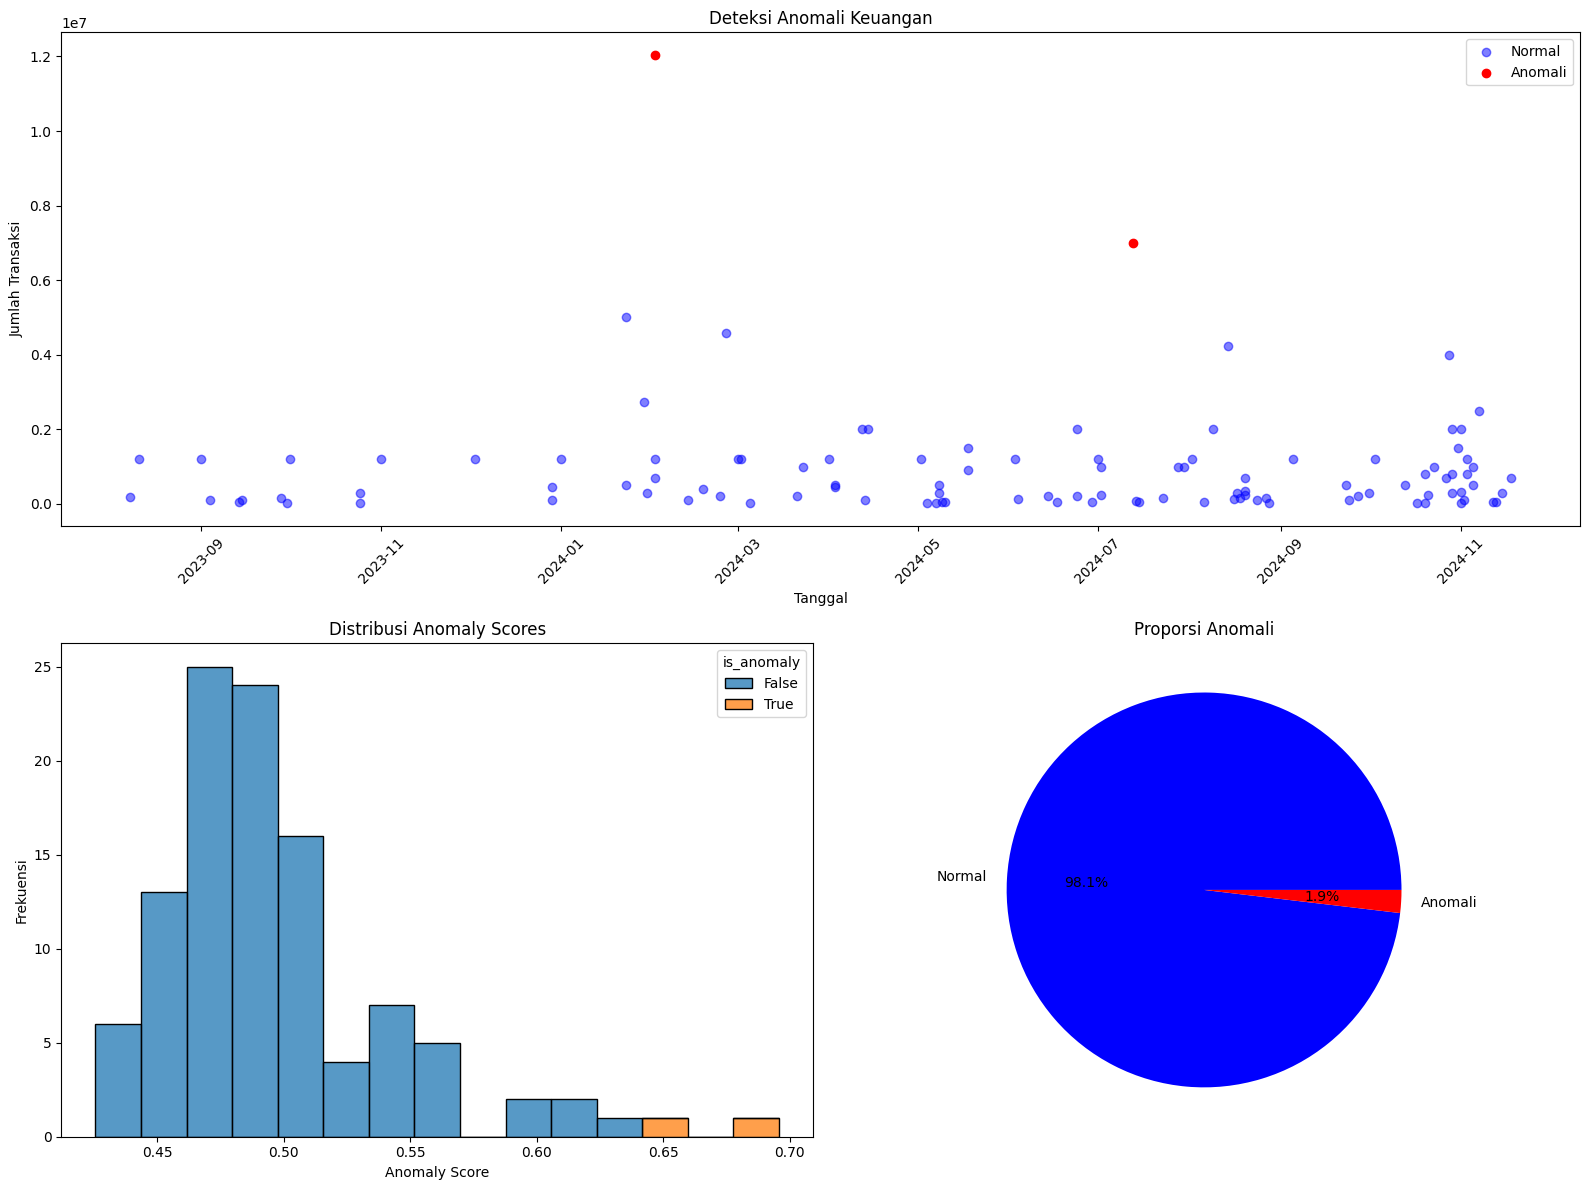

=== LAPORAN DETEKSI ANOMALI ===
Total Transaksi: 107
Jumlah Anomali: 2
Persentase Anomali: 1.87%

--- Detail Anomali ---
Tanggal: 2024-02-02
Jumlah: Rp 12,045,000.00
Anomaly Score: 0.6958
---
Tanggal: 2024-07-13
Jumlah: Rp 7,000,000.00
Anomaly Score: 0.6515
---


In [54]:
def main_income():
    detector = AdvancedFinancialAnomalyDetector(contamination=0.01)

    # Generate synthetic data
    data = pd.read_json('income_data.json')

    # Detect anomalies
    result = detector.detect_anomalies(data)

    # Visualisasi
    detector.visualize_anomalies(result)

    # Detailed Report
    detector.detailed_anomaly_report(result)

if __name__ == "__main__":
    main_income()

In [55]:
data = pd.read_json('income_data.json')

detector = AdvancedFinancialAnomalyDetector(contamination=0.01)
result = detector.detect_anomalies(data)

result.head(20)

,date,amount,day_of_week,month,day_of_month,is_anomaly,anomaly_score
0,2023-08-08,190000,1,8,8,False,0.443628
1,2023-08-11,1200000,4,8,11,False,0.456310
2,2023-09-01,1200000,4,9,1,False,0.458827
3,2023-09-04,100000,0,9,4,False,0.506006
4,2023-09-14,37000,3,9,14,False,0.440678
5,2023-09-15,100000,4,9,15,False,0.431062
6,2023-09-28,150000,3,9,28,False,0.465433
7,2023-09-30,20000,5,9,30,False,0.504419
8,2023-10-01,1200000,6,10,1,False,0.515941
9,2023-10-25,10000,2,10,25,False,0.467527


## **Pengeluaran**

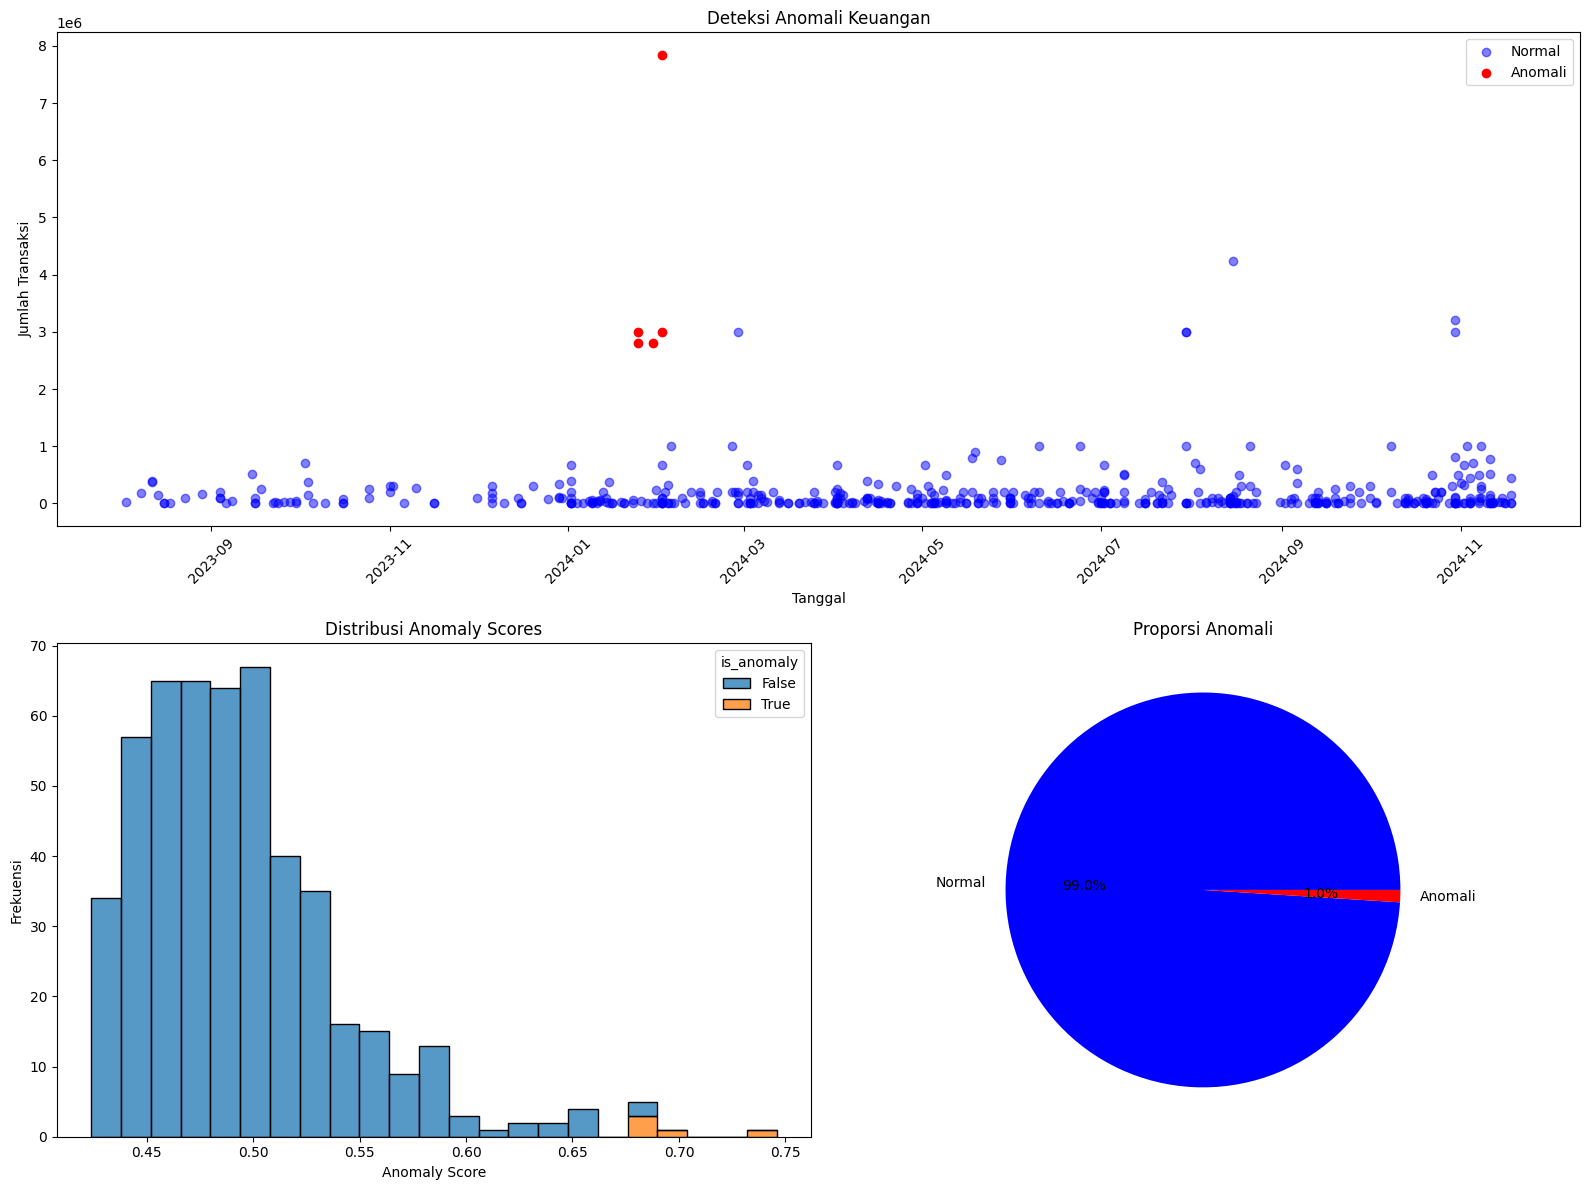

=== LAPORAN DETEKSI ANOMALI ===
Total Transaksi: 499
Jumlah Anomali: 5
Persentase Anomali: 1.00%

--- Detail Anomali ---
Tanggal: 2024-01-25
Jumlah: Rp 2,800,000.00
Anomaly Score: 0.6829
---
Tanggal: 2024-01-25
Jumlah: Rp 3,000,000.00
Anomaly Score: 0.6900
---
Tanggal: 2024-01-30
Jumlah: Rp 2,800,000.00
Anomaly Score: 0.6865
---
Tanggal: 2024-02-02
Jumlah: Rp 7,845,000.00
Anomaly Score: 0.7459
---
Tanggal: 2024-02-02
Jumlah: Rp 3,000,000.00
Anomaly Score: 0.6863
---


In [56]:
def main_expense():
    detector = AdvancedFinancialAnomalyDetector(contamination=0.01)

    # Read dataset
    data = pd.read_json('expense_data.json')

    # Detect anomalies
    result = detector.detect_anomalies(data)

    # Visualisasi
    detector.visualize_anomalies(result)

    # Detailed Report
    detector.detailed_anomaly_report(result)

if __name__ == "__main__":
    main_expense()

In [57]:
data = pd.read_json('expense_data.json')

detector = AdvancedFinancialAnomalyDetector(contamination=0.01)
result = detector.detect_anomalies(data)

result.head(20)

,date,amount,day_of_week,month,day_of_month,is_anomaly,anomaly_score
0,2023-08-03,20000,3,8,3,False,0.463986
1,2023-08-08,186450,1,8,8,False,0.458126
2,2023-08-12,384000,5,8,12,False,0.513872
3,2023-08-12,400000,5,8,12,False,0.518314
4,2023-08-14,150000,0,8,14,False,0.483677
5,2023-08-16,5500,2,8,16,False,0.425127
6,2023-08-16,2500,2,8,16,False,0.423990
7,2023-08-18,500,4,8,18,False,0.439420
8,2023-08-23,100000,2,8,23,False,0.455929
9,2023-08-29,164000,1,8,29,False,0.503797


## **Convert Model to TFJS**

In [58]:
saved_model_path = "./model_isolationforest.h5"

model.save(saved_model_path)

In [59]:
#Tensorflowjs converter

from tensorflow.keras.models import load_model

# Load the .h5 model
model = load_model('model_isolationforest.h5')

# Save the architecture to a JSON file
with open('model_isolationforest.json', 'w') as json_file:
    json_file.write(model.to_json())

# **Convert to JSON**

In [60]:
# data_for_export = {
#   "cashflow_analysis": [
#     {
#       "time": TIME[i].strftime('%Y-%m'),
#       "total_income": INCOME_SCALED[i],
#       "total_expense": EXPENSE_SCALED[i],
#       "net_cashflow": NET_CASHFLOW_SCALED[i]
#     }
#     for i in range(len(TIME))
#   ],
#     "anomaly_detection": [
#     {
#       "description": "Unusual spending detected in Marketing.",
#       "time": TIME[i].strftime('%Y-%m'),
#       "amount": EXPENSE_SCALED[i]
#     }
#     for i in range(len(TIME))
#   ],
#   "financial_advice": [
#     {
#       "time": TIME[i].strftime('%Y-%m'),
#       "advice": [
#         "Reduce unnecessary expenses in Marketing.",
#         "Consider increasing product offerings."
#       ]
#     }
#     for i in range(len(TIME))
#   ]
# }

# with open('clean_data.json', 'w') as json_file:
#     json.dump(data_for_export, json_file, indent=1)